# XUV flux

## is so uncertain...

MGS / March, 2023


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.units as u
import astropy.constants as c
from astropy.modeling import physical_models
import pandas as pd

from specutils import Spectrum1D

# Uncomment the next line if you have a MacBook with retina screen
%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = 9.0,6.5
pylab.rcParams['font.size'] = 18

### Start with black bodies as a sanity check

In [2]:
star_black_body_function = physical_models.BlackBody(temperature=6400*u.Kelvin)

Only go from 100 Å to 4000 Å.

In [3]:
wl = np.logspace(2, 3.6, num=1000) * u.Angstrom

In [4]:
black_body_spec = Spectrum1D(flux = star_black_body_function(wl), spectral_axis=wl)

### Facts about Helium

We want to scale the XUV portion of the spectrum, let's make it relative to 512 Angstrom photons, which ionize out of the ground state.

In [5]:
ground_state_ionization_threshold = (24.6 * u.eV).to(u.Angstrom, equivalencies=u.spectral())
metastable_ionization_threshold = (4.8 * u.eV).to(u.Angstrom, equivalencies=u.spectral())
ground_state_ionization_threshold, metastable_ionization_threshold

(<Quantity 504.00080664 Angstrom>, <Quantity 2583.00413403 Angstrom>)

### Facts about the star
We'll need these later

In [6]:
# HAT-P-67 b planetary parameters, measured
R_pl = 2.085  # Planetary radius in Jupiter radii
M_pl = 0.34  # Planetary mass in Jupiter masses
impact_parameter = 0.04  # Transit impact parameter
a_pl = 0.065  # Orbital semi-major axis in astronomical units

# HAT-P-67 b stellar parameters
R_star = 2.546  # Stellar radius in solar radii
M_star = 1.642  # Stellar mass in solar masses

Compute the stellar solid angle as seen from the planet `b` surface.

In [7]:
omega = np.pi*(R_star*u.Rsun)**2/(a_pl*u.AU)**2
omega = omega.to(u.steradian, equivalencies=u.dimensionless_angles())

### PHOENIX spectrum

In [8]:
from gollum.phoenix import PHOENIXSpectrum

In [9]:
stellar_spec = PHOENIXSpectrum(teff=6400, logg=3.5, wl_lo=1199.1, wl_hi=50_000)

stellar_spec = stellar_spec.new_flux_unit(u.erg/u.s/u.cm**2/u.Angstrom)
stellar_spec = stellar_spec/(np.pi*u.steradian) # convert to erg/cm^2/s/A/steradian
stellar_spec = stellar_spec * omega #flux_at_planet_surface

In [10]:
bolometric_flux = np.trapz(stellar_spec.flux, stellar_spec.wavelength)

### $\tau$ Boo XUV synthetic spectrum 
From Sanz-Forcada et al. 2011

In [11]:
df_F7 = pd.read_csv('../../data/literature/sanz_forcada2011/tauboo_simulspec.dat', comment='<', 
                    engine='python', sep='   ', skiprows=1, names=['wl_Angs', 'flux_photons'])

Convert units, from photons to eV to ergs.

In [12]:
spec_F7 = Spectrum1D(flux=df_F7.flux_photons.values*u.photon/u.s/u.cm**2, 
                     spectral_axis=df_F7.wl_Angs.values*u.Angstrom)

spec_F7 = Spectrum1D(flux=spec_F7.energy.value \
                     * df_F7.flux_photons.values*u.eV/u.s/u.cm**2/u.Angstrom\
                     / np.diff(spec_F7.bin_edges.value) , 
                     spectral_axis=df_F7.wl_Angs.values*u.Angstrom)
spec_F7 = spec_F7.new_flux_unit(u.erg/u.s/u.cm**2/u.Angstrom) 

Drop any zeros.

In [13]:
mask = spec_F7.flux.value != 0

In [14]:
spec_F7 = Spectrum1D(flux=spec_F7.flux[mask],
                     spectral_axis=spec_F7.wavelength[mask])

In [15]:
len(spec_F7.flux)

19736

In [16]:
mask = spec_F7.wavelength < ground_state_ionization_threshold

In [17]:
L_F7_ionizing = np.trapz(spec_F7.flux[mask], spec_F7.wavelength[mask])

### Set choices of $L_x/L_{bol}$ scaling terms

Let's say $10^{-6}$ and $10^{-4}$?

In [18]:
low_x = 1e-6
med_x = 1e-5
hig_x = 1e-4

In [19]:
low_x_spec = (spec_F7/L_F7_ionizing * bolometric_flux) * low_x
med_x_spec = (spec_F7/L_F7_ionizing * bolometric_flux) * med_x
hig_x_spec = (spec_F7/L_F7_ionizing * bolometric_flux) * hig_x

Now stitch together the x-ray spectrum with the photosphere spectrum...

In [20]:
from specutils.manipulation import LinearInterpolatedResampler

In [21]:
new_spectral_axis = np.concatenate([spec_F7.spectral_axis, stellar_spec.spectral_axis])

In [22]:
resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')

In [23]:
stitched_lowx = resampler(low_x_spec, new_spectral_axis) \
                         +resampler(stellar_spec, new_spectral_axis)

stitched_medx = resampler(med_x_spec, new_spectral_axis) \
                         +resampler(stellar_spec, new_spectral_axis)

stitched_higx = resampler(hig_x_spec, new_spectral_axis) \
                         +resampler(stellar_spec, new_spectral_axis)

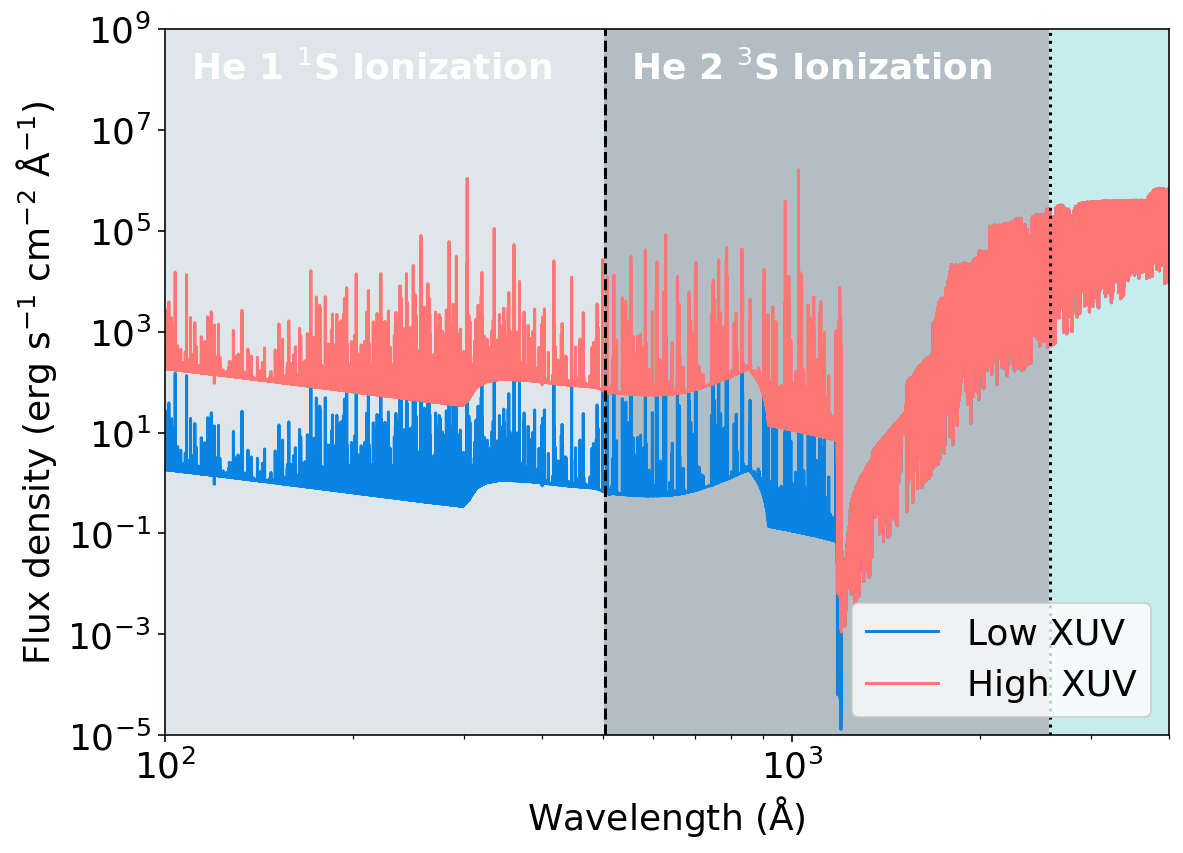

In [24]:
plt.plot(stitched_lowx.wavelength, stitched_lowx.flux, color='#0984e3', label='Low XUV')
plt.plot(stitched_higx.wavelength, stitched_higx.flux, color='#ff7675', label='High XUV')
x1 = 100
x2 = ground_state_ionization_threshold.value
x3 = metastable_ionization_threshold.value
plt.axvline(x2, color='k', linestyle='dashed')
plt.axvline(x3, color='k', linestyle='dotted')

plt.fill_between([x1, x2], 0, 1e9, color='#dfe6e9')
plt.fill_between([x2, x3], 0, 1e9, color='#b2bec3')
plt.fill_between([x3, 4000], 0, 1e9, color='#c7ecee')


plt.text(x1*1.1, 1e8, 'He 1 $^1$S Ionization', color='w', weight='heavy')
plt.text(x2*1.1, 1e8, 'He 2 $^3$S Ionization', color='w', weight='heavy')


plt.ylabel(r'Flux density (erg s$^{-1}$ cm$^{-2}$ ${\rm \AA}^{-1}$)')
plt.xlabel(r'Wavelength (${\rm \AA}$)')

plt.ylim(1E-5, 1E9)
plt.xlim(100, 4000)

plt.legend(loc='lower right')
plt.yscale('log')
plt.xscale('log')
plt.savefig('../../paper/paper1/figures/XUV_flux_schematic.png', bbox_inches='tight', dpi=300)

Looks good! We can save that as a figure to show how uncertain the XUV is...

Save to a file

In [25]:
stitched_lowx.write('../../data/literature/sanz_forcada2011/lowXUV_SED.fits', overwrite=True)
stitched_medx.write('../../data/literature/sanz_forcada2011/medXUV_SED.fits', overwrite=True)
stitched_higx.write('../../data/literature/sanz_forcada2011/higXUV_SED.fits', overwrite=True)